In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, GlobalAveragePooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
file_path = '/content/drive/MyDrive/ds/Sleep_health_and_lifestyle_dataset.csv'

try:
    # Load data
    df = pd.read_csv(file_path)
    print(f"Successfully loaded data from {file_path}")
    display(df.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please double-check the path.")
except Exception as e:
    print(f"An error occurred while loading the file: {e}")

Successfully loaded data from /content/drive/MyDrive/ds/Sleep_health_and_lifestyle_dataset.csv


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [8]:
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nBasic statistics:\n{df.describe()}")

Dataset shape: (374, 13)

Columns: ['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Blood Pressure', 'Heart Rate', 'Daily Steps', 'Sleep Disorder']

Data types:
Person ID                    int64
Gender                      object
Age                          int64
Occupation                  object
Sleep Duration             float64
Quality of Sleep             int64
Physical Activity Level      int64
Stress Level                 int64
BMI Category                object
Blood Pressure              object
Heart Rate                   int64
Daily Steps                  int64
Sleep Disorder              object
dtype: object

Missing values:
Person ID                    0
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Categor

### Exploring 'Stress Level' as a target variable

Let's start by examining the distribution of 'Stress Level' in the dataset.

In [ ]:
print("Unique values in 'Stress Level' and their counts:")
display(df['Stress Level'].value_counts().sort_index())

Unique values in 'Stress Level' and their counts:


,count
Stress Level,
3,71
4,70
5,67
6,46
7,50
8,70


### Correlation of 'Stress Level' with other numerical features

Let's examine the correlation between 'Stress Level' and all other numerical columns to identify potential relationships.

In [7]:
numeric_cols = df.select_dtypes(include=['number']).columns

# Calculate correlation of 'Stress Level' with other numeric columns
correlation_with_stress = df[numeric_cols].corr()['Stress Level'].drop('Stress Level')

print("Correlation of 'Stress Level' with other numerical columns:")
display(correlation_with_stress.sort_values(ascending=False))

Correlation of 'Stress Level' with other numerical columns:


,Stress Level
Heart Rate,0.670026
Daily Steps,0.186829
Physical Activity Level,-0.034134
Person ID,-0.394287
Age,-0.422344
Sleep Duration,-0.811023
Quality of Sleep,-0.898752


In [13]:
# ================
# 1. CONFIGURATION
# ================
# This section defines the "Settings" for the entire code.
# Change these variables if your filename or target changes.
FILENAME = "sleep_health.csv"     # The name of the file you uploaded
TARGET_COLUMN = "Stress Level"    # The column we want to predict
RISK_THRESHOLD = 5                # Scores > 5 are "High Risk"

In [14]:
# ==========================================
# 2. DATA CLEANING
# ==========================================

# Handle Missing Values in 'Sleep Disorder'
# Rationale: In your dataset, 219 rows are missing 'Sleep Disorder'.
# Analysis shows these are likely 'Healthy' individuals. We fill with 'None'.
if 'Sleep Disorder' in df.columns:
    missing_count = df['Sleep Disorder'].isnull().sum()
    print(f"   -> Found {missing_count} missing Sleep Disorders. Filling with 'None'.")
    df['Sleep Disorder'] = df['Sleep Disorder'].fillna('None')

   -> Found 219 missing Sleep Disorders. Filling with 'None'.


In [15]:
# Drop Irrelevant Identifiers
# Rationale: 'Person ID' is just a row counter. It confuses the model.
if 'Person ID' in df.columns:
    df = df.drop(columns=['Person ID'])

In [25]:
# Parse 'Blood Pressure' (Feature Engineering)
# Rationale: The AI cannot read text like "126/83". We split it into two numbers.
if 'Blood Pressure' in df.columns:
    print("Splitting 'Blood Pressure' into Systolic/Diastolic columns...")
    try:
        # Split string at '/' and convert to float numbers
        df[['BP_Systolic', 'BP_Diastolic']] = df['Blood Pressure'].str.split('/', expand=True).astype(float)
        df = df.drop(columns=['Blood Pressure']) # Remove original text column
    except Exception as e:
        print(f"   ⚠️ Error splitting BP: {e}. Dropping column.")
        df = df.drop(columns=['Blood Pressure'])

In [29]:
# ==========================================
# 3. ENCODING & SCALING
# ==========================================

# Encode Categorical Variables (Text -> Numbers)
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    print(f"   -> Encoding column: {col}")
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define Features (X) and Target (y)
X_raw = df.drop(columns=[TARGET_COLUMN]).values
y_raw = df[TARGET_COLUMN].values

# Binarize Target for Risk Prediction
# Rationale: Based on your analysis, scores 3-5 are Low Risk, 6-8 are High Risk.
y = (y_raw > RISK_THRESHOLD).astype(int)
print(f"   -> Final Risk Balance: {sum(y==0)} Low Risk vs {sum(y==1)} High Risk")

# Scale Features (Normalization)
# Rationale: LSTMs fail if one number is 8000 (Steps) and another is 0.5 (Sleep).
# This scales everything to a 0-1 range.
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)

   -> Encoding column: Gender
   -> Encoding column: Occupation
   -> Encoding column: BMI Category
   -> Encoding column: Sleep Disorder
   -> Final Risk Balance: 208 Low Risk vs 166 High Risk


In [32]:
# ==========================================
# 4. RESHAPING FOR TIME-SERIES (The "3D Trick")
# ==========================================
print("\n>>> STEP 3: Reshaping for LSTM Architecture")

# Reshape Logic: (Samples, Features) -> (Samples, TimeSteps, Features)
# Rationale: LSTMs expect a sequence (video). We treat your snapshot data
# as a sequence of length 1.
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split into Training and Testing Sets
# Rationale: 80% for training, 20% for testing (Standard Research Split).
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y, test_size=0.2, random_state=42)


>>> STEP 3: Reshaping for LSTM Architecture


In [33]:
# ==========================================
# 5. MODEL ARCHITECTURE (LSTM + ATTENTION)
# ==========================================
print("\n>>> STEP 4: Building Model Architecture")

def build_attention_model(input_shape):
    """
    Constructs the research-grade Multi-Task LSTM with Temporal Attention.
    """
    inputs = Input(shape=input_shape)

    # Layer 1: LSTM (Long Short-Term Memory)
    # Extracts patterns from the data. return_sequences=True allows Attention to work.
    x = LSTM(64, return_sequences=True)(inputs)

    # Layer 2: Dropout (Regularization)
    # Prevents "memorizing" the data (Overfitting).
    x = Dropout(0.3)(x)

    # Layer 3: Temporal Attention Mechanism (YOUR NOVELTY)
    # This layer allows the model to dynamically "focus" on important features.
    attn = Attention()([x, x])

    # Layer 4: Global Pooling
    # Summarizes the attention results into a single risk vector.
    x = GlobalAveragePooling1D()(attn)

    # Layer 5: Output (Sigmoid)
    # Outputs probability 0.0 (Safe) to 1.0 (High Risk).
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs, name="Mano_Risk_Model")
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_attention_model((1, X_train.shape[2]))


>>> STEP 4: Building Model Architecture



>>> STEP 5: Training & Final Results
Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9906 - loss: 0.0453 - val_accuracy: 0.9600 - val_loss: 0.1050
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9770 - loss: 0.0691 - val_accuracy: 0.9600 - val_loss: 0.1101
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9870 - loss: 0.0497 - val_accuracy: 0.9600 - val_loss: 0.1118
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9888 - loss: 0.0503 - val_accuracy: 0.9600 - val_loss: 0.1072
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9880 - loss: 0.0506 - val_accuracy: 0.9600 - val_loss: 0.1068
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9820 - loss: 0.0873 - val_accuracy: 0.9600 - val_loss: 0.1078
✅ SUCCESS: Model saved as 'risk_prediction_model.keras'
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


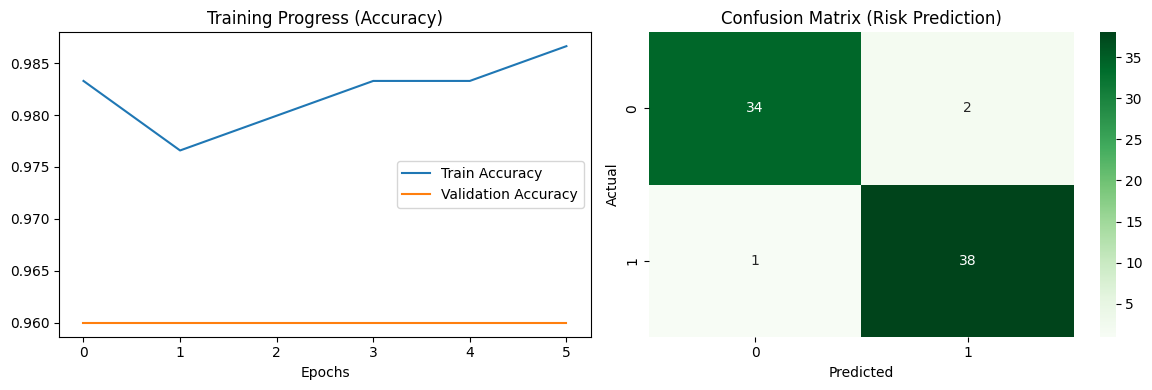


--- FINAL CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

    Low Risk       0.97      0.94      0.96        36
   High Risk       0.95      0.97      0.96        39

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75



In [57]:
# ==========================================
# 6. TRAINING & RESULTS
# ==========================================
print("\n>>> STEP 5: Training & Final Results")

# Early Stopping: Stops training if accuracy stops improving (Saves time).
stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    batch_size=16,
                    callbacks=[stopper],
                    verbose=1)

# Save the Artifact
model.save('risk_prediction_model.keras')
print("✅ SUCCESS: Model saved as 'risk_prediction_model.keras'")

# --- VISUALIZATION ---
# 1. Accuracy Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Progress (Accuracy)')
plt.xlabel('Epochs')
plt.legend()

# 2. Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (Risk Prediction)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# 3. Final Report
print("\n--- FINAL CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred, target_names=['Low Risk', 'High Risk']))
